Dataset import

In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harishkumardatalab/food-image-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'food-image-classification-dataset' dataset.
Path to dataset files: /kaggle/input/food-image-classification-dataset


In [17]:
import os
Path = f"{path}/Food Classification dataset"
classes = os.listdir(Path)

In [18]:
images = []
food_name = []

for file in classes:
    path = os.path.join(Path, file)
    all_files = os.listdir(path)
    for f in all_files:
        images.append(os.path.join(path, f))
        food_name.append(file)


In [19]:
import torch
import pandas as pd
df = pd.DataFrame(images , columns=["Image_path"])
df["food_items"] = food_name

In [20]:
samples_per_class = 100

train_df = (
    df.groupby("food_items", group_keys=False)
      .apply(lambda x: x.sample(
          n=samples_per_class,
          replace=len(x) < samples_per_class,
          random_state=42
      ))
      .reset_index(drop=True)
)

/tmp/ipython-input-3241000884.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


In [21]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["food_items"],
    random_state=42
)


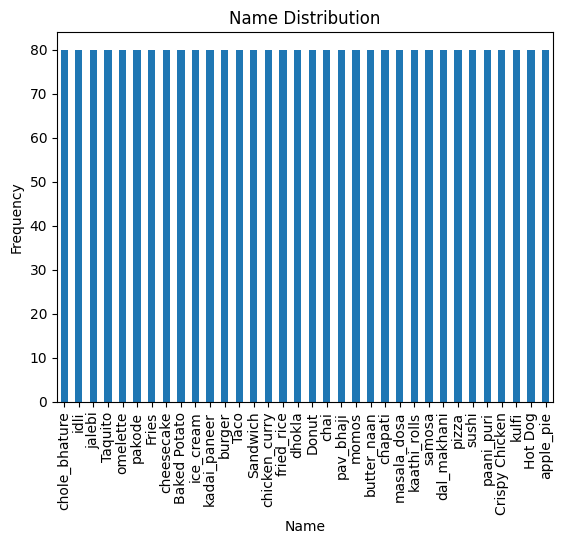

In [22]:
import matplotlib.pyplot as plt

train_df["food_items"].value_counts().plot(kind="bar")
plt.ylabel("Frequency")
plt.xlabel("Name")
plt.title("Name Distribution")
plt.show()


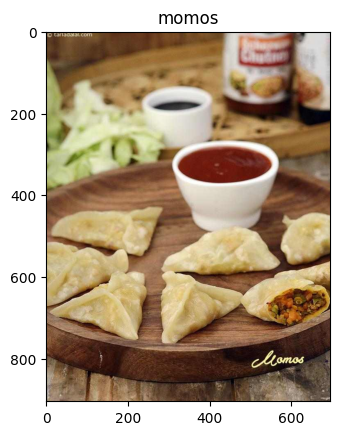

In [23]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.imshow(imread(images[1]))
plt.title(food_name[1])
plt.show()

In [24]:
classes = train_df["food_items"].unique()
class_to_idx = {c: i for i, c in enumerate(classes)}

In [25]:
from torchvision import transforms
Transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [26]:
from torch.utils.data import Dataset , DataLoader
from PIL import Image
import torch

class Food_Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]["Image_path"]
        label = self.df.iloc[index]["food_items"]

        image = Image.open(img_path).convert("RGB")
        label = class_to_idx[label]
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


In [27]:
training_data = Food_Dataset(train_df , transform = Transform)
train_dataloader = DataLoader(training_data , batch_size = 64 , shuffle = True)

In [36]:
import torch.nn as nn

class CNN_Model(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()

        # Feature extractor
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(dim, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),          # prevent overfitting
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
model = CNN_Model(3, len(class_to_idx)).to(device)
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = criterion(outputs, labels)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()

    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


Epoch: 1, Loss: 3.4729
Epoch: 2, Loss: 3.3783
Epoch: 3, Loss: 3.3063
Epoch: 4, Loss: 3.2393
Epoch: 5, Loss: 3.1891
Epoch: 6, Loss: 3.1308
Epoch: 7, Loss: 3.0778
Epoch: 8, Loss: 3.0300
Epoch: 9, Loss: 2.9956
Epoch: 10, Loss: 2.9368
Epoch: 11, Loss: 2.8987
Epoch: 12, Loss: 2.8581
Epoch: 13, Loss: 2.8281
Epoch: 14, Loss: 2.7978
Epoch: 15, Loss: 2.7643
Epoch: 16, Loss: 2.7366
Epoch: 17, Loss: 2.7122
Epoch: 18, Loss: 2.6755
Epoch: 19, Loss: 2.6538
Epoch: 20, Loss: 2.6335
Epoch: 21, Loss: 2.6120
Epoch: 22, Loss: 2.5885
Epoch: 23, Loss: 2.5594
Epoch: 24, Loss: 2.5209
Epoch: 25, Loss: 2.5275
Epoch: 26, Loss: 2.4989
Epoch: 27, Loss: 2.4768
Epoch: 28, Loss: 2.4510
Epoch: 29, Loss: 2.4146
Epoch: 30, Loss: 2.4034
Epoch: 31, Loss: 2.3751
Epoch: 32, Loss: 2.3737
Epoch: 33, Loss: 2.3650
Epoch: 34, Loss: 2.3546
Epoch: 35, Loss: 2.3212
Epoch: 36, Loss: 2.3029
Epoch: 37, Loss: 2.2849
Epoch: 38, Loss: 2.2803
Epoch: 39, Loss: 2.2585
Epoch: 40, Loss: 2.2381
Epoch: 41, Loss: 2.2357
Epoch: 42, Loss: 2.2101
E

In [39]:
testing_data = Food_Dataset(test_df, transform = Transform)
test_dataloader = DataLoader(testing_data , batch_size = 64 , shuffle = False)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 35.59%


with 1 convulation layer : 5% accuracy